In [29]:
# 远程启动命令.
"""
sudo docker run --gpus all -it --rm -p 8888:8888 -v /mnt/d/python_code/7spyder_projects/2024celeba/mnist/:/workspace  --ipc=host --ulimit memlock=-1 --ulimit stack=67108864 nvcr.io/nvidia/pytorch:23.08-py3
"""

'\nsudo docker run --gpus all -it --rm -p 8888:8888 -v /mnt/d/python_code/7spyder_projects/2024celeba/mnist/:/workspace  --ipc=host --ulimit memlock=-1 --ulimit stack=67108864 nvcr.io/nvidia/pytorch:23.08-py3\n'

In [30]:
# 导入相关的包.
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [31]:
# 硬件配置.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [32]:
# 获取原始数据.
# data_path = 'D:/python_code/7spyder_projects/2024celeba/mnist'
data_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = datasets.MNIST(root=data_path, 
                               train=True, 
                               transform=transform, 
                               download=False)  # download online， setting download=True. 


In [33]:
# 划分训练、验证与测试数据.
mnist_valid_dataset = Subset(mnist_dataset, 
                             torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, 
                             torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = datasets.MNIST(root=data_path, 
                                    train=False, 
                                    transform=transform, 
                                    download=False)

In [34]:
# 定义batchsize.
batch_size = 256

In [35]:
# 定义DataLoader.
train_dl = DataLoader(mnist_train_dataset, 
                      batch_size=batch_size, 
                      shuffle=True)

valid_dl = DataLoader(mnist_valid_dataset, 
                      batch_size=batch_size, 
                      shuffle=False)

In [36]:
# 检查一下数据集.
for images, labels in train_dl:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


**notes：**

假设卷积层输入神经元个数为$W$, 卷积核大小为$K$, 步长为$S$, 在输入两端各填补$P$个0(zero padding), 那么该卷积层的神经元数量为：

$$
\left\lfloor\frac{W + 2*P -K}{S}\right\rfloor + 1
$$

一般常用的卷积有如下三种：
* 窄卷积(Narrow Convolution): 步长为$S=1$, 两端不补零$P=0$, 对应Valid Padding, 卷积输出后长度为$W - k + 1$;
* 宽卷积(Wide Convolution): 步长为$S=1$, 两端补零$P=K-1$, 对应Full Padding, 卷积后出处长度为$W + K -1$;
* 等宽卷积(Equal-Width Convolution): 步长为$S=1$, 两端补零$P=(K -1)/2$, 对应Same Padding, 卷积后出长度为$W$.

In [37]:
# # 模型构建.
# class ConvNet(torch.nn.Module):
#     def __init__(self, num_classes):
#         super(ConvNet, self).__init__()

#         # 计算same padding.
#         # (w + 2*p - k)/s + 1 = o
#         # p = (s(o-1) - w + k)/2

#         # 28x28x1 => 28x28x8
#         self.conv_1 = nn.Conv2d(in_channels=1, 
#                                 out_channels=8, 
#                                 kernel_size=(3, 3),
#                                 stride=(1, 1), 
#                                 padding=1) # (1(28-1) - 28 + 3) / 2 = 1
#         # 28x28x8 => 14x14x8
#         self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2), 
#                                    stride=(2, 2), 
#                                    padding=0) # (2(14-1) - 28 + 2) = 0  

#         # 14x14x8 => 14x14x16
#         self.conv_2 = nn.Conv2d(in_channels=8, 
#                                 out_channels=16, 
#                                 kernel_size=(3, 3), 
#                                 stride=(1, 1), 
#                                 padding=1) # (1(14-1) - 14 + 3) / 2 = 1
#         # 14x14x16 => 7x7x16
#         self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2), 
#                                    stride=(2, 2), 
#                                    padding=0) # (2(7-1) - 14 + 2) = 0
#         self.linear_1 = nn.Linear(7*7*16, num_classes)

#         # 可选, 示例使用高斯分布.
#         """for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 m.weight.data.normal_(0.0, 0.01)
#                 m.bias.data.zero_()
#                 if m.bias is not None:
#                     m.bias.detach().zero_()"""
        
#     def forward(self, x):
#         out = self.conv_1(x)
#         out = nn.functional.relu(out)
#         out = self.pool_1(out)

#         out = self.conv_2(out)
#         out = nn.functional.relu(out)
#         out = self.pool_2(out)

#         logits = self.linear_1(out.view(-1, 7*7*16))
#         probas = nn.functional.softmax(logits, dim=1)
#         return logits



import torch
import torch.nn as nn

class ConvNet(torch.nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(ConvNet, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=1, 
                                out_channels=8, 
                                kernel_size=(3, 3),
                                stride=(1, 1), 
                                padding=1)
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2), 
                                   stride=(2, 2), 
                                   padding=0)
        
        self.conv_2 = nn.Conv2d(in_channels=8, 
                                out_channels=16, 
                                kernel_size=(3, 3), 
                                stride=(1, 1), 
                                padding=1)
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2), 
                                   stride=(2, 2), 
                                   padding=0)

        self.linear_1 = nn.Linear(7*7*16, num_classes)

        # 添加 Dropout 层
        self.dropout_1 = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        out = self.conv_1(x)
        out = nn.functional.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = nn.functional.relu(out)
        out = self.pool_2(out)
        out = self.dropout_1(out)  # 在池化后添加的 Dropout

        logits = self.linear_1(out.view(-1, 7*7*16))
        probas = nn.functional.softmax(logits, dim=1)
        return logits

In [38]:
# "软件配置".
torch.manual_seed(1)

learn_rate = 0.001
num_epochs = 30

num_classes = 10

dropout_probability = 0.15  # 设置 Dropout 概率，可以根据实际需要进行调整
model = ConvNet(num_classes, dropout_prob=dropout_probability)
model = model.to(device)


In [39]:
# 定义损失函数与优化器.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [40]:
# 定义训练循环.
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val acc: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [41]:
# 训练评估.
torch.manual_seed(1)

hist = train(model, num_epochs=num_epochs, train_dl=train_dl, valid_dl=valid_dl)

Epoch 1 accuracy: 0.7820 val acc: 0.9146
Epoch 2 accuracy: 0.9193 val acc: 0.9431
Epoch 3 accuracy: 0.9433 val acc: 0.9579
Epoch 4 accuracy: 0.9556 val acc: 0.9669
Epoch 5 accuracy: 0.9625 val acc: 0.9700
Epoch 6 accuracy: 0.9678 val acc: 0.9729
Epoch 7 accuracy: 0.9696 val acc: 0.9731
Epoch 8 accuracy: 0.9724 val acc: 0.9773
Epoch 9 accuracy: 0.9750 val acc: 0.9784
Epoch 10 accuracy: 0.9765 val acc: 0.9795
Epoch 11 accuracy: 0.9773 val acc: 0.9815
Epoch 12 accuracy: 0.9777 val acc: 0.9796
Epoch 13 accuracy: 0.9790 val acc: 0.9816
Epoch 14 accuracy: 0.9803 val acc: 0.9813
Epoch 15 accuracy: 0.9808 val acc: 0.9839
Epoch 16 accuracy: 0.9814 val acc: 0.9824
Epoch 17 accuracy: 0.9815 val acc: 0.9836
Epoch 18 accuracy: 0.9830 val acc: 0.9849
Epoch 19 accuracy: 0.9832 val acc: 0.9847
Epoch 20 accuracy: 0.9835 val acc: 0.9847
Epoch 21 accuracy: 0.9834 val acc: 0.9838
Epoch 22 accuracy: 0.9840 val acc: 0.9859
Epoch 23 accuracy: 0.9846 val acc: 0.9847
Epoch 24 accuracy: 0.9853 val acc: 0.9862
E

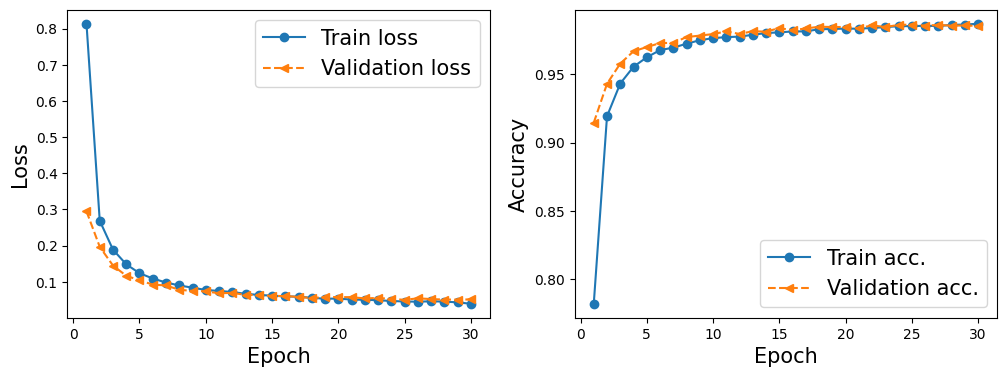

In [42]:
# 绘制学习曲线.
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
# 查看model在CPU还是GPU上.
device = next(model.parameters()).device
print(f'Model is on: {device}')

Model is on: cuda:0


In [ ]:
# 定义测试 DataLoader, 如果在GPU上测试推理.
test_dl = DataLoader(mnist_test_dataset, 
                     batch_size=batch_size, 
                     shuffle=False)

correct = 0
total = 0

model.eval()
with torch.no_grad(): 
    for data in test_dl:
        images, labels = data
        
        # 确保输入数据也转移到 GPU.
        if torch.cuda.is_available():
            images = images.to('cuda')
            model.to('cuda')

        # 进行预测.
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 取出最大值的索引作为预测结果.
        
        total += labels.size(0)  # 统计总样本数.
        correct += (predicted.cpu() == labels).sum().item()  # 统计正确预测的数量.

# 计算并打印测试准确率.
test_accuracy = correct / total
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.9883


In [ ]:
# 或者--测试验证.
"""
确保所有在GPU上的计算完成，并同步主机和设备。它会阻塞主线程，直到所有未完成的CUDA操作都完成。
这样可以防止数据状态不一致的问题，确保后续操作在做预测时是稳定的。
"""
torch.cuda.synchronize()

model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9883


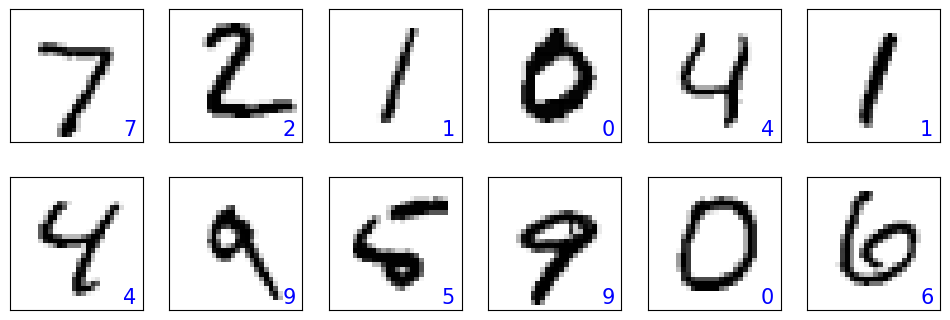

In [47]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1)) # alternatively: mnist_test_dataset.data[i].float()
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
plt.show()

In [ ]:
torch.save(model, 'model.pth')
# 直接加载模型
loaded_model = torch.load('model.pth')
# 如果模型是在训练模式中，需要设置为 eval 模式
loaded_model.eval()


# 假设 model 是你的模型
torch.save(model.state_dict(), 'model_state_dict.pth')
# 重新创建模型的实例
model = ConvNet(num_classes, dropout_prob=dropout_probability)  # ConvNet模型的定义类
model.load_state_dict(torch.load('model_state_dict.pth'))
# 需要设置为 eval 模式如果进行推断
model.eval()